In [129]:
import datetime
import pandas as pd 
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from collections import namedtuple
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import warnings
from HackathonPackage import CovidModels #Hackthon package contains the "backend" class for the models
#plt.ioff()
#warnings.filterwarnings("ignore")
#pd.set_option('display.max_columns', None) #setting to view all columns in the output

In [130]:
df = pd.read_csv("C:\\Users\\dylan.levine\\Development\\Covid Hackathon\\CovidDataset.csv", engine='python', encoding = "utf-8-sig", parse_dates=['date'])
print(df.head())

iso_code continent      country state county  fips       date  total_cases  \
0      AFG      Asia  Afghanistan   N\A    N\A     0 2019-12-31          0.0   
1      AFG      Asia  Afghanistan   N\A    N\A     0 2020-01-01          0.0   
2      AFG      Asia  Afghanistan   N\A    N\A     0 2020-01-02          0.0   
3      AFG      Asia  Afghanistan   N\A    N\A     0 2020-01-03          0.0   
4      AFG      Asia  Afghanistan   N\A    N\A     0 2020-01-04          0.0   

   new_cases  total_deaths  ...  gdp_per_capita  extreme_poverty  \
0        0.0           0.0  ...        1803.987              NaN   
1        0.0           0.0  ...        1803.987              NaN   
2        0.0           0.0  ...        1803.987              NaN   
3        0.0           0.0  ...        1803.987              NaN   
4        0.0           0.0  ...        1803.987              NaN   

   cvd_death_rate diabetes_prevalence  female_smokers  male_smokers  \
0             NaN                9.59    

In [131]:
RMSESummaryStates = pd.read_pickle("C:\\Users\\dylan.levine\\Development\\Covid Hackathon\\BacktestPersistedData\\stateBackTestRMSEResults.pk1")
RMSESummaryCountrys = pd.read_csv("C:\\Users\\dylan.levine\\Development\\Covid Hackathon\\BacktestPersistedData\\RSMECountries.csv").set_index("country")
#RMSESummaryStates.index.unique()[0]
#RMSESummaryStates.reset_index(inplace=True)

df_rawdata = df


In [132]:
RMSESummaryCountrys

,sarimax_RMSE,sarimaxExog_RMSE,var_RMSE,LSTM_Full_RMSE,BestModel
country,,,,,
Afghanistan,556.117594,629.385759,2.189685e+02,9655.545947,var_RMSE
Albania,71.820168,28.863974,1.288723e+02,524.332693,sarimaxExog_RMSE
Algeria,1027.663190,1044.394827,9.268261e+02,1155.045054,var_RMSE
Andorra,0.753154,7.784821,2.956953e+01,33.148653,sarimax_RMSE
Angola,38.454971,19.721358,9.928350e+01,140.171202,sarimaxExog_RMSE
...,...,...,...,...,...
Western Sahara,319.667349,319.667349,1.000000e+09,491.494142,sarimax_RMSE
World,289788.237754,304786.019303,1.000000e+09,811179.637145,sarimax_RMSE
Yemen,28.757233,86.757624,8.628731e+01,194.427522,sarimax_RMSE


In [122]:
def GenerateStatePredictions(df, df_rawdata, predictDate):
     #empty dictionary to append values too
    resultList = []
    total = len(RMSESummaryStates.index.values) #counts total len of states to track status
    count = 0
    for state in df.index.values:
        if count < 1000:
            print(state)
            #Initialize variables
            #temporaryResultsDF = pd.DataFrame() 
            tempResultDict = {}
            stateRecord = df.loc[[state]] #returns the RMSE comparisons record for the selected state
            ModelGenerator = CovidModels.HackathonModels(df_rawdata, state) 
            stateDF = ModelGenerator.getstatedf(fields=['date','total_cases']).asfreq('D').fillna(0) #asfreq fills in missing 
            
            #Generates ARIMA model
            if stateRecord.BestModel.values[0] == 'sarimax_RMSE':
                print("ARIMA")
                ARIMAstatePred = ModelGenerator.run_sarimax(stateDF,predictDate)[0] #run sarimax returns the ARIMA model without exog
                tempResultDict['state'] = state
                tempResultDict['predictDate'] = predictDate
                tempResultDict['total_cases_predict'] = ARIMAstatePred.loc[predictDate].new_cases_predict
                tempResultDict['model'] = "sarimax_RMSE"
                resultList.append(tempResultDict)
            #Generate ARIMA model with exogenous log fitten curve
            if stateRecord.BestModel.values[0] == 'sarimaxExog_RMSE':
                print("ARIMA exog")
                exogDF = ModelGenerator.getSigmoidFit(stateDF, predictDate) #4th degree polynomial fitting to historical data
                statePred = ModelGenerator.run_sarimax_exog(stateDF,exogDF, predictDate)[0] #run sarimax exog returns arima model with exog
                tempResultDict['state'] = state
                tempResultDict['predictDate'] = predictDate
                tempResultDict['total_cases_predict'] = statePred.loc[predictDate].new_cases_predict
                tempResultDict['model'] = "sarimaxExog_RMSE"
                resultList.append(tempResultDict)
            #Temporarily generating ARIMA model, to be overriden by the LTSM model when it is finalized
            if stateRecord.BestModel.values[0] == 'LSTM_Full_RMSE':
                print("LSTM, ARIMA temporary")
                ARIMA2statePred = ModelGenerator.run_sarimax(stateDF,predictDate)[0] #run sarimax returns the ARIMA model without exog  
                tempResultDict['state'] = state
                tempResultDict['predictDate'] = predictDate
                tempResultDict['total_cases_predict'] = ARIMA2statePred.loc[predictDate].new_cases_predict
                tempResultDict['model'] = "sarimax_RMSE"
                resultList.append(tempResultDict)
            count += 1            
            print(str(total - count) + " remaining")
    return resultList

results = GenerateStatePredictions(RMSESummaryStates,df_rawdata, "2020-08-05")
results


NameError: name 'country' is not defined

In [114]:
#Saves results to CSV and a pickled dataframe
resultsDF = pd.DataFrame(results) #dictionary format of [dict1level,dict1level,dict1level] converts easily to DF
resultsDF.to_pickle("C:\\Users\\dylan.levine\\Development\\Covid Hackathon\\FinalPredictions\\StatePredictions.pk1")
resultsDF.to_csv("C:\\Users\\dylan.levine\\Development\\Covid Hackathon\\FinalPredictions\\StatePredictions.csv")

In [133]:
def GenerateCountryPredictions(df, df_rawdata, predictDate):
     #empty dictionary to append values too
    resultList = []
    total = len(RMSESummaryCountrys.index.values) #counts total len of states to track status
    count = 0
    for country in df.index.values:
        #if country == "United States Virgin Islands":
        if count < 1000: #arbritrary count value to get all countries
            print(country)
            #Initialize variables
            tempResultDict = {}
            countryRecord = df.loc[[country]] #returns the RMSE comparisons record for the selected state
            ModelGenerator = CovidModels.HackathonModels(df_rawdata, country) 
            countryDF = ModelGenerator.getcountrydf(fields=['date','total_cases']).asfreq('D').fillna(0) #asfreq fills in missing 
            
            #Generates ARIMA model
            if countryRecord.BestModel.values[0] == 'sarimax_RMSE':
                try:
                    print("ARIMA")
                    ARIMAcountryPred = ModelGenerator.run_sarimax(countryDF,predictDate)[0] #run sarimax returns the ARIMA model without exog
                    tempResultDict['country'] = country
                    tempResultDict['predictDate'] = predictDate
                    tempResultDict['total_cases_predict'] = ARIMAcountryPred.loc[predictDate].new_cases_predict
                    tempResultDict['model'] = "sarimax_RMSE"
                    resultList.append(tempResultDict)
                except:
                    tempResultDict['country'] = country
                    tempResultDict['predictDate'] = predictDate
                    tempResultDict['total_cases_predict'] = None
                    tempResultDict['model'] = "sarimax_RMSE"
                    resultList.append(tempResultDict)
            #Generate ARIMA model with exogenous log fitten curve
            if countryRecord.BestModel.values[0] == 'sarimaxExog_RMSE':
                try:
                    print("ARIMA exog")
                    exogDF = ModelGenerator.getSigmoidFit(countryDF, predictDate) #4th degree polynomial fitting to historical data
                    countryPred = ModelGenerator.run_sarimax_exog(countryDF,exogDF, predictDate)[0] #returns arima model with exog
                    tempResultDict['country'] = country
                    tempResultDict['predictDate'] = predictDate
                    tempResultDict['total_cases_predict'] = countryPred.loc[predictDate].new_cases_predict
                    tempResultDict['model'] = "sarimaxExog_RMSE"
                    resultList.append(tempResultDict)
                except:
                    tempResultDict['country'] = country
                    tempResultDict['predictDate'] = predictDate
                    tempResultDict['total_cases_predict'] = None
                    tempResultDict['model'] = "sarimaxExog_RMSE"
                    resultList.append(tempResultDict)                    

            #Generate VAR model with endo stringency index
            if countryRecord.BestModel.values[0] == 'var_RMSE':
                try:
                    print("ARIMA exog")
                    countryPredVar = ModelGenerator.getcountrydf(fields=['date','total_cases', 'stringency_index']).asfreq('D').fillna(0)
                    
                    #This section should be a part of the class method, to refactor later if ever needed
                    delta = countryPredVar[-1:].index - datetime.datetime.strptime(predictDate, "%Y-%m-%d")
                    projectionDelta = abs(int(delta.days.values[0])) - 1

                    vardfpred = ModelGenerator.run_VAR_MAVGStringency_tc(countryPredVar, projectionDelta) #Var model predictions df
                    
                    tempResultDict['country'] = country
                    tempResultDict['predictDate'] = predictDate
                    tempResultDict['total_cases_predict'] = vardfpred.loc[predictDate].total_cases_predict
                    tempResultDict['model'] = "var_RMSE"
                    resultList.append(tempResultDict)            
                except:
                    tempResultDict['country'] = country
                    tempResultDict['predictDate'] = predictDate
                    tempResultDict['total_cases_predict'] = None
                    tempResultDict['model'] = "var_RMSE"
                    resultList.append(tempResultDict)                      

            #Temporarily generating ARIMA model, to be overriden by the LTSM model when it is finalized
            if countryRecord.BestModel.values[0] == 'LSTM_Full_RMSE':
                try:
                    print("LSTM, ARIMA temporary")
                    ARIMA2countryPred = ModelGenerator.run_sarimax(countryDF,predictDate)[0] #run sarimax returns the ARIMA model without exog  
                    tempResultDict['country'] = country
                    tempResultDict['predictDate'] = predictDate
                    tempResultDict['total_cases_predict'] = ARIMA2countryPred.loc[predictDate].new_cases_predict
                    tempResultDict['model'] = "sarimax_RMSE"
                    resultList.append(tempResultDict)
                except:
                    tempResultDict['country'] = country
                    tempResultDict['predictDate'] = predictDate
                    tempResultDict['total_cases_predict'] = None
                    tempResultDict['model'] = "sarimax_RMSE"
                    resultList.append(tempResultDict)

            count += 1            
            print(str(total - count) + " remaining")
            countryResultsDF.to_pickle("C:\\Users\\dylan.levine\\Development\\Covid Hackathon\\FinalPredictions\\InProgressCountryPredictions.pk1") #Persists latest result in case of function exit
    return resultList

countryResults = GenerateCountryPredictions(RMSESummaryCountrys,df_rawdata, "2020-08-05")
countryResults

Afghanistan
ARIMA exog
total_cases
MovingAvgStringency
209 remaining
Albania
ARIMA exog
208 remaining
Algeria
ARIMA exog
total_cases
MovingAvgStringency
207 remaining
Andorra
ARIMA
206 remaining
Angola
ARIMA exog
205 remaining
Anguilla
LSTM, ARIMA temporary
204 remaining
Antigua and Barbuda
ARIMA exog
203 remaining
Argentina
ARIMA
202 remaining
Armenia
ARIMA exog
201 remaining
Aruba
ARIMA exog
total_cases
MovingAvgStringency
200 remaining
Australia
ARIMA exog
total_cases
MovingAvgStringency
199 remaining
Austria
ARIMA exog
total_cases
MovingAvgStringency
198 remaining
Azerbaijan
ARIMA
197 remaining
Bahamas
ARIMA
196 remaining
Bahrain
ARIMA
195 remaining
Bangladesh
ARIMA exog
194 remaining
Barbados
ARIMA exog
total_cases
MovingAvgStringency
193 remaining
Belarus
ARIMA exog
192 remaining
Belgium
ARIMA
191 remaining
Belize
ARIMA exog
total_cases
MovingAvgStringency
190 remaining
Benin
LSTM, ARIMA temporary
189 remaining
Bermuda
ARIMA exog
total_cases
MovingAvgStringency
188 remaining
Bhut

rimaxExog_RMSE'},
 {'country': 'Denmark',
  'predictDate': '2020-08-05',
  'total_cases_predict': 13622.970289150388,
  'model': 'sarimaxExog_RMSE'},
 {'country': 'Djibouti',
  'predictDate': '2020-08-05',
  'total_cases_predict': 5537.0,
  'model': 'var_RMSE'},
 {'country': 'Dominica',
  'predictDate': '2020-08-05',
  'total_cases_predict': 17.999981127613545,
  'model': 'sarimaxExog_RMSE'},
 {'country': 'Dominican Republic',
  'predictDate': '2020-08-05',
  'total_cases_predict': 72259.46185519491,
  'model': 'sarimax_RMSE'},
 {'country': 'Ecuador',
  'predictDate': '2020-08-05',
  'total_cases_predict': 86306.48439360928,
  'model': 'sarimax_RMSE'},
 {'country': 'Egypt',
  'predictDate': '2020-08-05',
  'total_cases_predict': 95398.56504399469,
  'model': 'sarimaxExog_RMSE'},
 {'country': 'El Salvador',
  'predictDate': '2020-08-05',
  'total_cases_predict': 17756.0,
  'model': 'var_RMSE'},
 {'country': 'Equatorial Guinea',
  'predictDate': '2020-08-05',
  'total_cases_predict': 307

In [134]:
#Saves results to CSV and a pickled dataframe
countryResultsDF = pd.DataFrame(countryResults) #dictionary format of [dict1level,dict1level,dict1level] converts easily to DF
countryResultsDF.to_pickle("C:\\Users\\dylan.levine\\Development\\Covid Hackathon\\FinalPredictions\\PrelimCountryPredictions.pk1")
countryResultsDF.to_csv("C:\\Users\\dylan.levine\\Development\\Covid Hackathon\\FinalPredictions\\PrelimCountryPredictions.csv")
countryResultsDF

,country,predictDate,total_cases_predict,model
0,Afghanistan,2020-08-05,3.760900e+04,var_RMSE
1,Albania,2020-08-05,5.718967e+03,sarimaxExog_RMSE
2,Algeria,2020-08-05,3.449100e+04,var_RMSE
3,Andorra,2020-08-05,9.262667e+02,sarimax_RMSE
4,Angola,2020-08-05,1.591204e+03,sarimaxExog_RMSE
...,...,...,...,...
205,Western Sahara,2020-08-05,1.037689e+03,sarimax_RMSE
206,World,2020-08-05,1.811089e+07,sarimax_RMSE
207,Yemen,2020-08-05,1.937760e+03,sarimax_RMSE
208,Zambia,2020-08-05,6.265318e+03,sarimax_RMSE


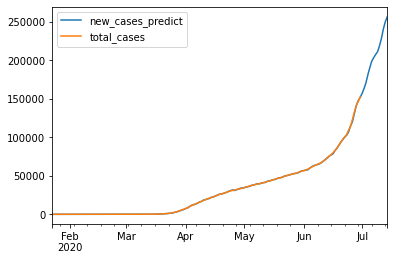

,new_cases_predict,total_cases
2020-01-23,0.000000,0.0
2020-01-24,0.000000,0.0
2020-01-25,0.000000,0.0
2020-01-26,0.000000,0.0
2020-01-27,0.000000,0.0
...,...,...
2020-07-10,218705.232967,NaN
2020-07-11,228379.160419,NaN
2020-07-12,240640.404579,NaN
2020-07-13,249890.790299,NaN


In [17]:
from HackathonPackage import CovidModels

ModelGenerator = CovidModels.HackathonModels(df, "FL") 

stateDF = ModelGenerator.getstatedf(fields=['date','total_cases']).asfreq('D').fillna(0) #asfreq fills in missing dates in the index and fillna replaces the missing dates with 0 value
stateDF_compare = stateDF
stateDF = stateDF[:"2020-06-30"]
statePred = ModelGenerator.run_sarimax(stateDF,"2020-07-14")[0] #returns a DF of predicted cases and original 

#statePred = statePred.merge(stateDF_compare, how='left', right_index=True, left_index=True)
statePred.plot()
plt.show()
plt.close()

statePred



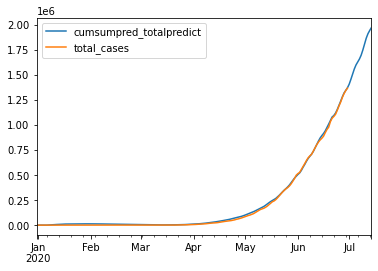

In [3]:
ModelGenerator = CovidModels.HackathonModels(df, "Brazil") #creates a HackathonModels object for FL

stateDF = ModelGenerator.getcountrydf(fields=['date','new_cases']).asfreq('D').fillna(0)
stateDF = stateDF[:"2020-06-30"]
exogDF = ModelGenerator.getPolynomialFit(stateDF, "2020-07-14") 
statePred = ModelGenerator.run_sarimax_exog(stateDF,exogDF, "2020-07-14")[0]
stateDF = ModelGenerator.getcountrydf(fields=['date','total_cases']).asfreq('D').fillna(0)
stateDF = stateDF[:"2020-06-30"]
statePred = statePred.fillna(0)
statePred['cumsumpred_totalpredict'] = statePred.new_cases_predict.values.cumsum()

statePred = statePred.merge(stateDF,how="left", right_index=True, left_index=True)
statePred[['cumsumpred_totalpredict', 'total_cases']].plot()
plt.show()
plt.close()


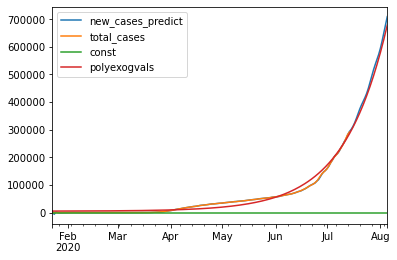

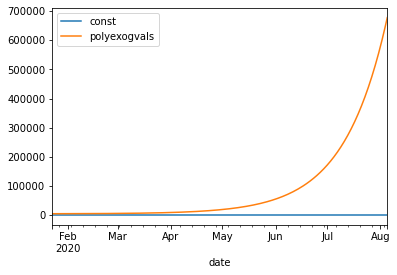

,new_cases_predict,total_cases,const,polyexogvals
2020-01-23,5558.271120,0.0,1.0,5468.593920
2020-01-24,-6245.530266,0.0,1.0,5480.190013
2020-01-25,1580.709890,0.0,1.0,5492.257177
2020-01-26,77.340142,0.0,1.0,5504.814549
2020-01-27,-824.602813,0.0,1.0,5517.882043
...,...,...,...,...
2020-08-01,594037.957487,NaN,1.0,578769.469841
2020-08-02,620610.309873,NaN,1.0,602070.186688
2020-08-03,650427.748591,NaN,1.0,626317.434759
2020-08-04,680686.659493,NaN,1.0,651549.663561


In [6]:
from HackathonPackage import CovidModels
#http://www.healthdata.org/sites/default/files/files/research_articles/2020/CovidModel_Appendix.pdf

ModelGenerator = CovidModels.HackathonModels(df, "FL") #creates a HackathonModels object for FL
stateDF = ModelGenerator.getstatedf(fields=['date','total_cases']).asfreq('D').fillna(0)
#stateDF = stateDF.loc[:'2020-07-14'] #Limits date for backtesting purposes

exogDF = ModelGenerator.getSigmoidFit(stateDF, "2020-08-05") #4th degree polynomial fitting to historical data
#exogGen = ModelGenerator.getSigmoidFit(sigmoidFitDF, "2020-07-14")
statePred = ModelGenerator.run_sarimax_exog(stateDF,exogDF, "2020-08-05")[0] #returns a DF of predicted cases and original new_Cases
statePred = statePred.merge(exogDF, how="left", left_index=True, right_index=True)
statePred.plot() #produces the prediction plot through 2020-07-20. Going to add our other model approachs as methods as well (i.e. run_var(), run_iterative_sarimax())
exogDF.plot()
plt.show()
statePred


In [99]:
ModelGenerator = CovidModels.HackathonModels(df, "Denmark") #creates a HackathonModels object for Germany

vardf = ModelGenerator.getcountrydf(fields=['date','total_cases', 'stringency_index'])

delta = vardf[-1:].index - datetime.datetime.strptime("2020-08-05", "%Y-%m-%d")
projectionDelta = abs(int(delta.days.values[0])) - 1

print(projectionDelta)
predictions = ModelGenerator.run_VAR_MAVGStringency_tc(vardf, projectionDelta)
predictions[['total_cases', 'total_cases_predict']].plot()
predictions[['MovingAvgStringency', 'MovingAvgStringency_predict']].plot()
#plt.show()
#plt.close()
predictions.loc['2020-08-05'].total_cases_predict




15
total_cases
MovingAvgStringency


13528.0

In [54]:
predictions.loc["2020-07-30"].total_cases_predict

13505.0